In [1]:
# load packages
library(sf)
library(raster)
library(viridis)
library(virtualspecies)
library(ggplot2)
library(tidyverse)
library(terra)
library(stars)
library(geodata)
library(purrr)
library(reshape2)

Warning message:
"il pacchetto 'sf' è stato creato con R versione 4.1.3"
Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 7.2.1; sf_use_s2() is TRUE

Warning message:
"il pacchetto 'raster' è stato creato con R versione 4.1.3"
Caricamento del pacchetto richiesto: sp

Warning message:
"il pacchetto 'sp' è stato creato con R versione 4.1.3"
Caricamento del pacchetto richiesto: viridisLite

Caricamento del pacchetto richiesto: terra

Warning message:
"il pacchetto 'terra' è stato creato con R versione 4.1.3"
terra 1.7.23

Warning message:
"il pacchetto 'tidyverse' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'tibble' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'tidyr' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'readr' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'purrr' è stato creato con R versione 4.1.3"
Warning message:
"il pacchetto 'dplyr' è stato creato con R versione 4.1.3"
Warning message:
"il p

To begin, we will download climate data from [WorldClim](https://www.worldclim.org/).
Climate data are among the datasets from which the suitability of a species can be calculated. 

In this simple example, we will download only 3 variables: minimum temperature, maximum temperature, and precipitation.
The study area is Luxembourg. 


In [6]:
## Download climatic data 
# worldclim_country function. 
# The res paramater is the resolution, with valid values as 10,5,2.5 and 0.5 
# The var parameter is the variable name, with valid values as tmin, tmax, tavg, prec, wind, vapr and bio.
# The worldclim_country function will return 12 layers of raster (in a SpatRaster), for each variable. 

tmin <- worldclim_country("Lux", "tmin", path=tempdir(), res = 0.5, version = "2.1")

In [7]:
tmax <- worldclim_country("Lux", "tmax", path=tempdir(), res = 0.5, version = "2.1")

In [8]:
prec <- worldclim_country("Lux", "prec", path=tempdir(), res = 0.5, version = "2.1")

In [ ]:
# load from local dir
# writeRaster(tmin, "data/tmin.tif", overwrite=FALSE)
# writeRaster(tmax, "data/tmax.tif", overwrite=FALSE)
# writeRaster(prec, "data/prec.tif", overwrite=FALSE)

# tmin <- rast("data/tmin.tif")
# tmax <- rast("data/tmax.tif")
# prec <- rast("data/tmax.tif")

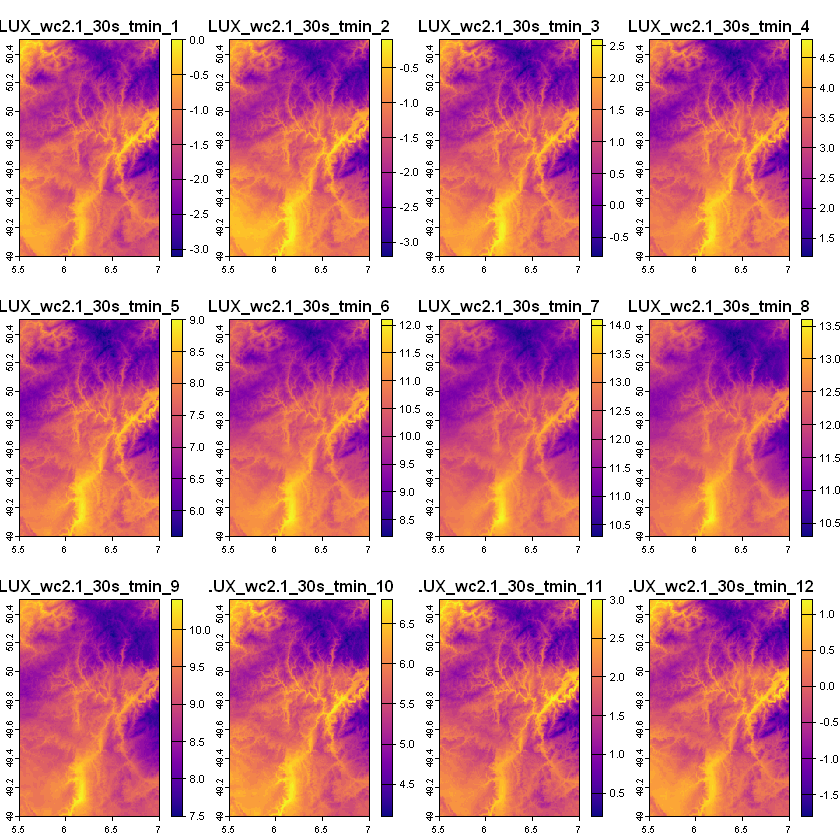

In [9]:
# 12 months of precipitation in Luxembourg. Each layer represents the average value for a month.
plot(tmin, col = plasma(500, alpha = 1, begin = 0, end = 1, direction = 1))

Even if there are 12 rasters, each corresponding to a month, the temporal dimension is not expressed in the RasterStack and **needs to be added** by `time` function


In [10]:
# here, we will simply use numbers from 1 to 12 to represent # the months.
time(tmin) <- time(tmax) <- time(prec) <- 1:12
climate_vars <- c("tmin", "tmax", "prec")

print(tmin)

class       : SpatRaster 
dimensions  : 180, 180, 12  (nrow, ncol, nlyr)
resolution  : 0.008333333, 0.008333333  (x, y)
extent      : 5.5, 7, 49, 50.5  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : LUX_wc2.1_30s_tmin.tif 
names       : LUX_w~min_1, LUX_w~min_2, LUX_w~min_3, LUX_w~min_4, LUX_w~min_5, LUX_w~min_6, ... 
min values  :        -3.1,        -3.2,        -0.8,         1.2,         5.6,         8.2, ... 
max values  :         0.0,        -0.1,         2.6,         4.8,         9.0,        12.1, ... 
time (raw)  : 1 to 12 



## Stars Data Cube
The [stars R package](https://r-spatial.github.io/stars/) provides an infrastructure for managing **data cubes**. Data cubes are multi-dimensional arrays that enable the organization and analysis of large datasets across multiple dimensions, such as time, space, and various environmental variables.

We will create a stars object that contains the climatic variables as attributes and x and y as dimensions. This way, we have everything we need to proceed into a single object.

In [ ]:
# first, we create a list that contains all the stacks, to which we apply st_as_stars.
stars_clima <- list(tmin, tmax, prec) %>%
  lapply(st_as_stars) %>%
  do.call("c", .) %>%
  setNames(climate_vars)

In [ ]:
print(stars_clima)

## Virtual Species
The purpose of this brief tutorial is to construct a data structure that allows for the comparison of suitability between two species occupying the same area over time.

As an example, we will consider only two species and two months to observe changes in suitability. The suitability of a real species can be obtained by applying **Species Distribution Models (SDMs)**. But in our case, since we are interested in creating the structure, we will use [virtualspecies](https://borisleroy.com/files/virtualspecies-tutorial.html), which are artificial species randomly generated.

During the creation of these random virtual species, the first step involves generating suitability based on the initial environmental data: in our case, the climatic data.

We will calculate the suitability for each species over the first two months, january and february. 

In [ ]:
# Let's choose to work with the first two months. For both months, we will create a stack containing the 3 climatic variables.

# number of months
num_months <- 2

In [ ]:
# list of RasterStacks for each month
raster_stacks <- map(1:num_months, function(month) {

   # extraction and convertion of the climatic variables
    layers <- map(climate_vars, function(var) {
     as(stars_clima[var,,,month], "Raster")  
     # convertion into rasters
    })

  # layer stack of the current month
  stack_month <- stack(layers)
  # names
  names(stack_month) <- climate_vars
  return(stack_month)
})

In [ ]:
january <- raster_stacks[[1]]
february <- raster_stacks[[2]]

In [ ]:
print(january)

In [ ]:
plot(january, col = plasma(500, alpha = 1, begin = 0, end = 1, direction = 1))

The following function uses the `generateRandomSp` function from the `virtualspecies` , which creates random species based on the stack of climatic variables and allows us to set some parameters.

Each time the function is executed, a new random species is generated. Therefore, to ensure that we obtain the same species, we need to set a fixed seed using `set.seed()`


In [ ]:
generate_suitability <- function(climate_stack, seed_value) {
  set.seed(seed_value)  # Assicura che la specie virtuale sia riproducibile
  random_sp <- generateRandomSp(raster.stack = climate_stack,
                                convert.to.PA = FALSE,
                                species.type = "multiplicative",
                                approach = "response",
                                relations = "gaussian",
                                realistic.sp = TRUE,
                                plot = FALSE)
  
  return(random_sp$suitab.raster)
}

In [ ]:
# generate the suitability for species 1 in January and February and create a single object for species 1 that contains the suitability for both months
suit_sp1_jan <- generate_suitability(january, seed_value = 121)
suit_sp1_feb <- generate_suitability(february, seed_value = 121)
suit_sp1 <- c(suit_sp1_feb, suit_sp1_jan)

In [ ]:
# same for species 2
suit_sp2_jan <- generate_suitability(january, seed_value = 456)
suit_sp2_feb <- generate_suitability(february, seed_value = 456)
suit_sp2 <- c(suit_sp2_feb, suit_sp2_jan) 

In [ ]:
# add time dimension
time(suit_sp2) <- time(suit_sp1) <- 1:2  

In [ ]:
# suitability for Species 1
plot(suit_sp1, col = viridis(500, alpha = 1, begin = 0, end = 1, direction = 1))
title("Suitability of Species 1 in Jan-Feb", outer=TRUE, line=-0.9)

In [ ]:
# suitability for Species 2
plot(suit_sp2, col = viridis(500, alpha = 1, begin = 0, end = 1, direction = 1))
title("Suitability of Species 2 in Jan-Feb", outer=TRUE, line=-0.9)


For each species, we will create a data cube: the dimensions remain x, y, and time, but this time the attribute is the suitability only, with values ranging from 0 to 1, which characterizes each species.

In [ ]:
# stars cube for Species 1
suit_sp1 <- list(suit_sp1)
suit_cube_sp1 <- do.call("c", lapply(suit_sp1, stars::st_as_stars)) %>% setNames(., c("suit"))
print(suit_cube_sp1)

In [ ]:
# stars cube for Species 2
suit_sp2 <- list(suit_sp2)
suit_cube_sp2 <- do.call("c", lapply(suit_sp2, stars::st_as_stars)) %>% setNames(., c("suit"))
print(suit_cube_sp2)

## Virtual Data Cube

We want to incorporate both species into the same object.

To combine the two species into a single object, we need to collapse the x and y dimensions into one, creating a grid that represents individual cells within the study area. This grid allows us to reduce the dimensions of the stars object and facilitates the transition to a **vector data cube**.

In this process, pixels in the raster are grouped based on their spatial intersection with a set of vector geometries. Each group is then reduced to a single value using an aggregation function, such as the mean or maximum. The result is a one-dimensional sequence of feature geometries defined in space.

By creating the grid, it is possible to reduce two dimensions (x and y) into a single one (cell): this way, we can observe the suitability over time for both species within the defined polygons. As a result, "species" becomes an additional dimension in our data structure.

In [ ]:
# bounding box
bb_lux <- st_bbox(tmin)

In [ ]:
# from bounding box to polygon
sf_lux <- st_as_sfc(bb_lux) %>% 
  st_sf()

In [ ]:
# grid
lux_grid <- st_make_grid(sf_lux, cellsize = .1, n = c(100, 100), what = "polygons", square = FALSE, offset = st_bbox(sf_lux)[c("xmin", "ymin")]) %>% 
  st_as_sf() %>% 
  mutate(id = 1:nrow(.))

In [ ]:
# plot raster with grid
# Convert SpatRaster to dataframe
tmin_df <- as.data.frame(tmin$LUX_wc2.1_30s_tmin_1, xy = TRUE, na.rm = TRUE)

ggplot() +
  # Add raster layer
  geom_raster(data = tmin_df, aes(x = x, y = y, fill = LUX_wc2.1_30s_tmin_1)) +
  scale_fill_viridis_c(alpha = 1, begin = 0, end = 1, option = "viridis") +
  # Add grid
  geom_sf(data =lux_grid, color = "black", size = 0.5, fill = NA) +
  theme_void() +
  theme(
    legend.position = "none",
    panel.border = element_blank(),
    plot.margin = margin(0, 0, 0, 0)
  )

In [ ]:
# aggregate by cells, calculating the average of the suitability values within each cell
# species 1
agg_sp1 <- aggregate(suit_cube_sp1, lux_grid, mean, as_points = TRUE, na.action = na.omit)
print(agg_sp1)

In [ ]:
# species 2
agg_sp2 <- aggregate(suit_cube_sp2, lux_grid, mean, as_points = TRUE, na.action = na.omit)
print(agg_sp2)

Finally, we merge the two cubes. Now the dimensions are 3 again: cell, time and species. The attribute represents the species' suitability over time and space.

In [ ]:
cube_sp1sp2 <- c(agg_sp1, agg_sp2) %>%  
  st_redimension() %>% 
  st_set_dimensions(., which = "new_dim", values = c("specie1","specie2"), names = "species") %>%
  st_set_dimensions(., which = "time", values = c("jan","feb"), names = "month") %>% 
  
  setNames(.,"suitability")

print(cube_sp1sp2)

Let's suppose we have a specific point in space: we want to investigate the suitability of the two species at that location
With `pull` function you can extract the attributes in a specific point of space and time.

In [ ]:
# first, we need to identify the corresponding cell for that location.
which_cell <- st_sf(geometry = st_sfc(st_point(c(5.5, 49.0)), crs = 4326))  %>%  st_join(., lux_grid) 
print(which_cell$id)

In [ ]:
# this object provides, for each species (,,1) and (,,2), the suitability in January and February in cell 10
# in the first case, it decreased; in the second, it increased.
pull(cube_sp1sp2[,10,,], "suitability")

In [11]:
## we can better visualize this information this way:
values_suit <- pull(cube_sp1sp2[,10,,], "suitability")

ERROR: Error in pull(cube_sp1sp2[, 10, , ], "suitability"): oggetto 'cube_sp1sp2' non trovato


In [ ]:
# transform values_suit into a long format without rewriting it
df_long <- melt(values_suit)
colnames(df_long) <- c("cell", "time", "species", "suitability")

In [ ]:
# convert time and species into factors
df_long$time <- factor(df_long$time, labels = c("Jan", "Feb"))
df_long$species <- factor(df_long$species, labels = c("Species 1", "Species 2"))

In [ ]:
# plot
ggplot(df_long, aes(x = species, y = suitability, color = species)) +
  geom_point(size = 3) +
  facet_wrap(~time, scales = "free_x", ncol = 2, strip.position = "bottom") + 
  labs(title = "Suitability for species in January and February",
       x = "Month",
       y = "Suitability") +
  scale_color_manual(values = c("Species 1" = "purple2", "Species 2" = "orange")) + 
  theme_minimal() +
  theme(
    axis.text.x = element_blank(), 
    axis.ticks.x = element_blank(),            
    panel.spacing = unit(2, "lines"),          
    axis.line = element_line(color = "black", size = 0.8),
    strip.placement = "outside", 
    legend.position = "right",                 
    panel.border = element_rect(color = "black", fill = NA, size = 0.))


## References
* virtualspecies, an R package to generate virtual species distributions (2018), Leroy B. et al., [DOI](https://doi.org/10.1111/ecog.01388)
* Pebesma E, Bivand R (2023). Spatial Data Science: With applications in R. Chapman and Hall/CRC, London. DOI:10.1201/9780429459016, [https://r-spatial.org/book/](https://r-spatial.org/book/)
* Meyer H, Milà C, Ludwig M, Linnenbrink J, Schumacher F (2024). CAST: 'caret' Applications for Spatial-Temporal Models. R package version 1.0.2, [https://hannameyer.github.io/CAST/](https://github.com/HannaMeyer/CAST)
* Gilardi A, Lovelace R (2024). osmextract: Download and Import Open Street Map Data Extracts. R package version 0.5.1.900, [https://github.com/ropensci/osmextract](https://docs.ropensci.org/osmextract/).
* Predicting species distribution: offering more than simple habitat models, Guisan A., Thuiller W., 2005, [DOI](https://doi.org/10.1111/j.1461-0248.2005.00792.x)
* A practical overview of transferability in species distribution modeling, Werkowska W., Marquez A., Real R., Acevedo P., 2017,  [DOI](https://cdnsciencepub.com/doi/abs/10.1139/er-2016-0045)
* Effect of roadside bias on the accuracy of predictive maps produced by bioclimatic models, Kadmon R., Farber O., Danin A., 2004, [DOI](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/02-5364)
* The virtual ecologist approach: simulating data and observers, Zurell et al., 2010, [DOI](https://nsojournals.onlinelibrary.wiley.com/doi/full/10.1111/j.1600-0706.2009.18284.x)
* The n-dimensional hypervolume, Blonder et al., 2014, [DOI](https://onlinelibrary.wiley.com/doi/full/10.1111/geb.12146)
* The cumulative niche approach: a framework to assess the performance of ecological niche model projections, Arlè et al., 2024, [DOI](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.11060)
